<a href="https://colab.research.google.com/github/FalconMadhab/Plant-Disease-Detection/blob/master/Plant_diseased_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI app that detects diseases in plants using Facebook’s deep learning platform: PyTorch

# Importing the libraries
The notebook was made on Google Colab.

In [1]:
# We need pillow version of 5.3.0
# We will uninstall the older version first
!pip uninstall -y Pillow
# Install the new one
!pip install Pillow==5.3.0
# Let's verify the version
# This should print 5.3.0. If it doesn't, then restart runtime:
# Menu > Runtime > Restart Runtime
!pip install image
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.48 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


    100% |████████████████████████████████| 484.0MB 55.8MB/s 
fastai 1.0.48 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.48 has requirement torch>=1.0.0, but you'll have torch 0.4.0 which is incompatible.
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2
5.3.0


In [2]:
# Verfication that GPU is available in the Google Colab.
# Following should print: CUDA is available!  Training on GPU ...
# if it prints otherwise, then enable GPU: 
# From Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


# Loading the data

We have used 'torchvision'  to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). 

The dataset is split into two parts, training and validation. 
For the training, we have applied transformations such as random scaling, cropping, and flipping to genralize for better performance.

The validation set was used to measure the model's performance on data it hasn't seen yet. For this, the crop images were resized to the appropriate size.

The pre-trained networks available from 'torchvision' were trained on the ImageNet dataset where each color channel was normalized separately. For both sets we have normalized the means and standard deviations of the images to what the network expects. 

For the means, it's ' [0.485, 0.456, 0.406]'  and for the standard deviations ''[0.229, 0.224, 0.225]' , as calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
# Download the dataset and unzip de folder
!gdown https://drive.google.com/uc?id=1Bhh3VeMBH6F7vKqHdDDmdyi-7RfvQNqJ
!tar -xvf PlantVillage.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1Bhh3VeMBH6F7vKqHdDDmdyi-7RfvQNqJ
To: /content/PlantVillage.tar.gz
830MB [00:11, 74.3MB/s]
PlantVillage/val/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/b9bfa8c8-2e32-4a0c-8ac5-aa2b57e9df73___RS_GLSp 4579 copy.jpg
PlantVillage/train/Blueberry___healthy/b2cd377c-7dc6-4ed8-9cf9-b0a07635552f___RS_HL 0475.JPG
PlantVillage/train/Orange___Haunglongbing_(Citrus_greening)/b04811ec-74c9-4025-812d-9a7bd8f2e930___CREC_HLB 4816.JPG
PlantVillage/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/30e776ef-d0e8-4ca0-bd28-767553054db9___YLCV_GCREC 1985.JPG
PlantVillage/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/ff8a2419-99e2-4bb8-ba94-691cb9773930___YLCV_GCREC 5393.JPG
PlantVillage/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/2c8b2d0d-2948-463d-ad63-e0805e1e2c9d___YLCV_GCREC 5443.JPG
PlantVillage/val/Apple___Black_rot/6e21042a-928f-4e40-81bf-3a103ff52765___JR_FrgE.S 2938.JPG
PlantVillage/train/Tomato___Late_blight/c991e311-e10c-4505-a01a-3ad7c92d3e

In [0]:
#Organizing the dataset
data_dir = '/PlantVillage'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

# Label mapping

Importing json to map them into a particular category.

In [0]:
import json

with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)
    

In [0]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'PlantVillage'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'PlantVillage'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Using the image datasets and the trainforms, defining the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

# Building and training the classifier


In [34]:
# Build and training of network

# 1. Loading resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freezing parameters

for param in model.parameters():
    param.requires_grad = False
 
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
# 2. Defining a new, untrained feed-forward network as a classifier, using ReLU activations

# Our input_size matches the in_features of pretrained model


from collections import OrderedDict


# Creating the classifier ordered dictionary first

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 39)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
model.fc = classifier

In [0]:
#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)


        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)


                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
# Train a model with a pre-trained network
num_epochs = 10
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Using GPU: True
Epoch 1/10
----------
train Loss: 0.7603 Acc: 0.7781
val Loss: 0.3047 Acc: 0.9038

Epoch 2/10
----------
train Loss: 0.4493 Acc: 0.8564
val Loss: 0.2300 Acc: 0.9249

Epoch 3/10
----------
train Loss: 0.3980 Acc: 0.8739
val Loss: 0.2428 Acc: 0.9224

Epoch 4/10
----------
train Loss: 0.3736 Acc: 0.8803
val Loss: 0.2175 Acc: 0.9318

Epoch 5/10
----------
train Loss: 0.3519 Acc: 0.8876
val Loss: 0.2047 Acc: 0.9358

Epoch 6/10
----------
train Loss: 0.2491 Acc: 0.9193
val Loss: 0.1296 Acc: 0.9567

Epoch 7/10
----------
train Loss: 0.2270 Acc: 0.9262
val Loss: 0.1249 Acc: 0.9589

Epoch 8/10
----------
train Loss: 0.2306 Acc: 0.9263
val Loss: 0.1313 Acc: 0.9561

Epoch 9/10
----------
train Loss: 0.2201 Acc: 0.9279
val Loss: 0.1337 Acc: 0.9554

Epoch 10/10
----------
train Loss: 0.2199 Acc: 0.9305
val Loss: 0.1257 Acc: 0.9565

Training complete in 176m 11s
Best valid accuracy: 0.958924


In [0]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))



In [17]:
test(model, dataloaders, device)

Testing Accuracy: 0.003
Testing Accuracy: 0.006
Testing Accuracy: 0.008
Testing Accuracy: 0.011
Testing Accuracy: 0.014
Testing Accuracy: 0.017
Testing Accuracy: 0.020
Testing Accuracy: 0.022
Testing Accuracy: 0.025
Testing Accuracy: 0.028
Testing Accuracy: 0.030
Testing Accuracy: 0.033
Testing Accuracy: 0.036
Testing Accuracy: 0.039
Testing Accuracy: 0.041
Testing Accuracy: 0.044
Testing Accuracy: 0.047
Testing Accuracy: 0.049
Testing Accuracy: 0.052
Testing Accuracy: 0.055
Testing Accuracy: 0.058
Testing Accuracy: 0.061
Testing Accuracy: 0.063
Testing Accuracy: 0.066
Testing Accuracy: 0.069
Testing Accuracy: 0.072
Testing Accuracy: 0.074
Testing Accuracy: 0.077
Testing Accuracy: 0.080
Testing Accuracy: 0.083
Testing Accuracy: 0.085
Testing Accuracy: 0.088
Testing Accuracy: 0.091
Testing Accuracy: 0.093
Testing Accuracy: 0.096
Testing Accuracy: 0.099
Testing Accuracy: 0.101
Testing Accuracy: 0.104
Testing Accuracy: 0.107
Testing Accuracy: 0.109
Testing Accuracy: 0.112
Testing Accuracy

# Save the checkpoint

We have saved the model so we can load it later for making predictions. 

We have saved the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

In [0]:
# Save the checkpoint 

model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'plants9615_checkpoint.pth')

# Loading the checkpoint

We have written a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [19]:
#Download the trained model from here: 
!gdown https://drive.google.com/uc?id=1D3mWC5AAWlx3OdU4yljt7vtEPrpLFtmZ

Downloading...
From: https://drive.google.com/uc?id=1D3mWC5AAWlx3OdU4yljt7vtEPrpLFtmZ
To: /content/plants9615_checkpoint.pth
246MB [00:06, 40.8MB/s]


In [0]:
# Function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    
    input_size = 2048
    output_size = 39
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 39)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('plants9615_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

# Inference for classification

We have made a function to use a trained network for inference. That is, we pass an image into the network and predict the class of the plant disease in the image.


In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):

    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Class Prediction


In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.'''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [24]:
print (predict('PlantVillage/val/Blueberry___healthy/06eacfab-fb39-40e0-bbce-927bc98fa2ac___RS_HL 2663.JPG', loaded_model))

(array([9.9871051e-01, 4.5131423e-04, 4.0855847e-04, 2.2177442e-04,
       6.1075451e-05], dtype=float32), ['Blueberry___healthy', 'Apple___Apple_scab', 'Apple___healthy', 'Peach___Bacterial_spot', 'Apple___Black_rot'])


# Checking

Checking to make sure that even if the validation accuracy is high, it's always good to check that there aren't any bugs. 

In [0]:
# Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

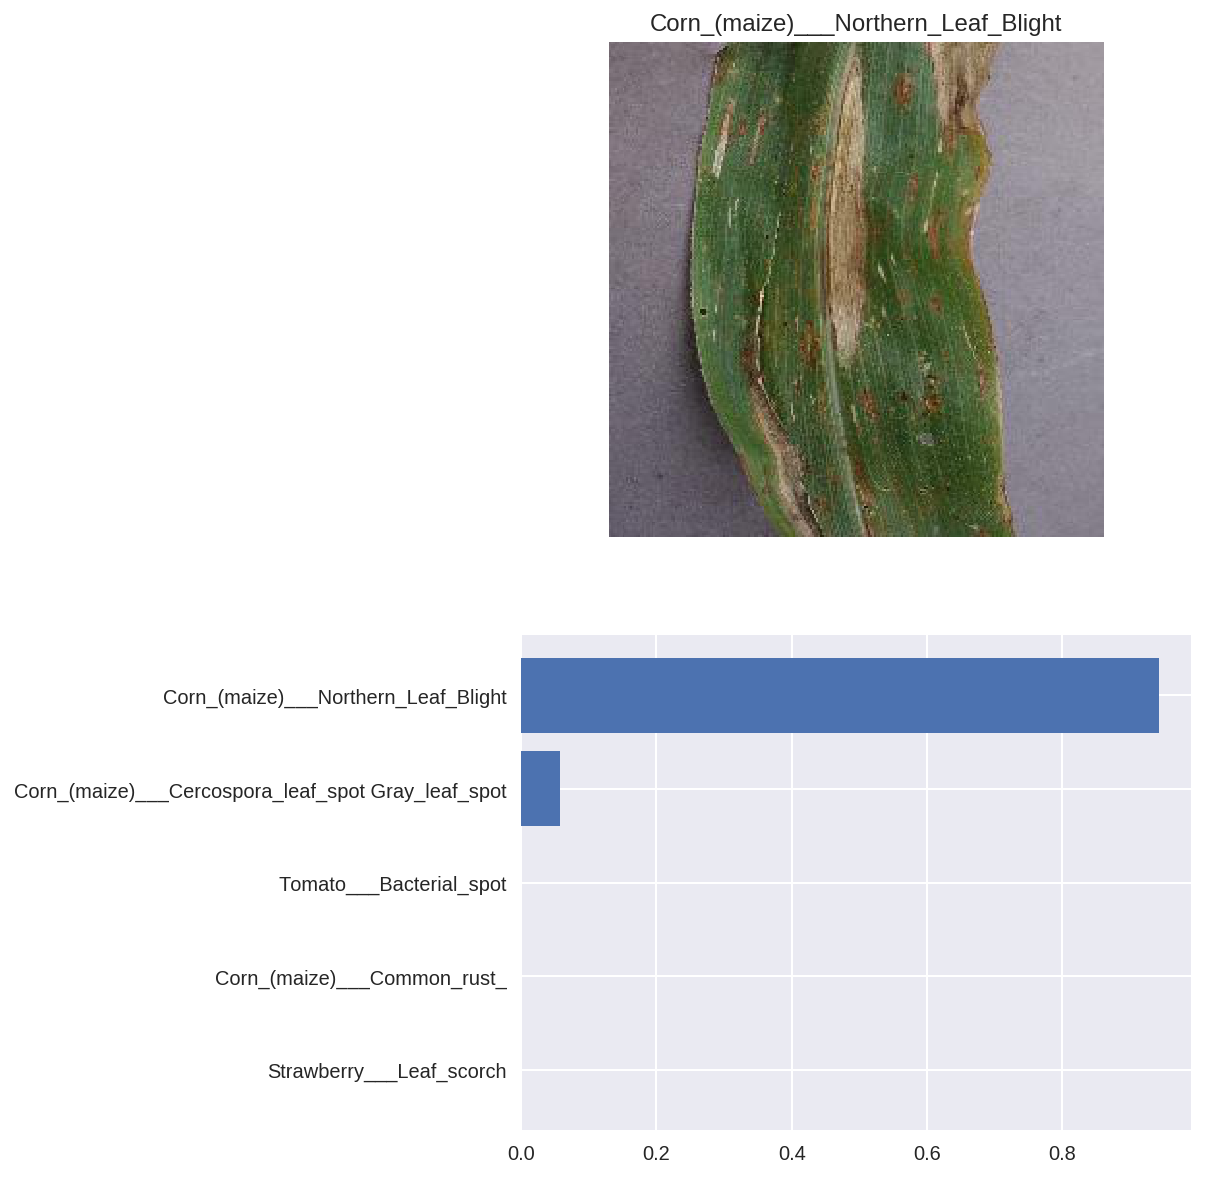

In [32]:
img = 'PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG'

p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

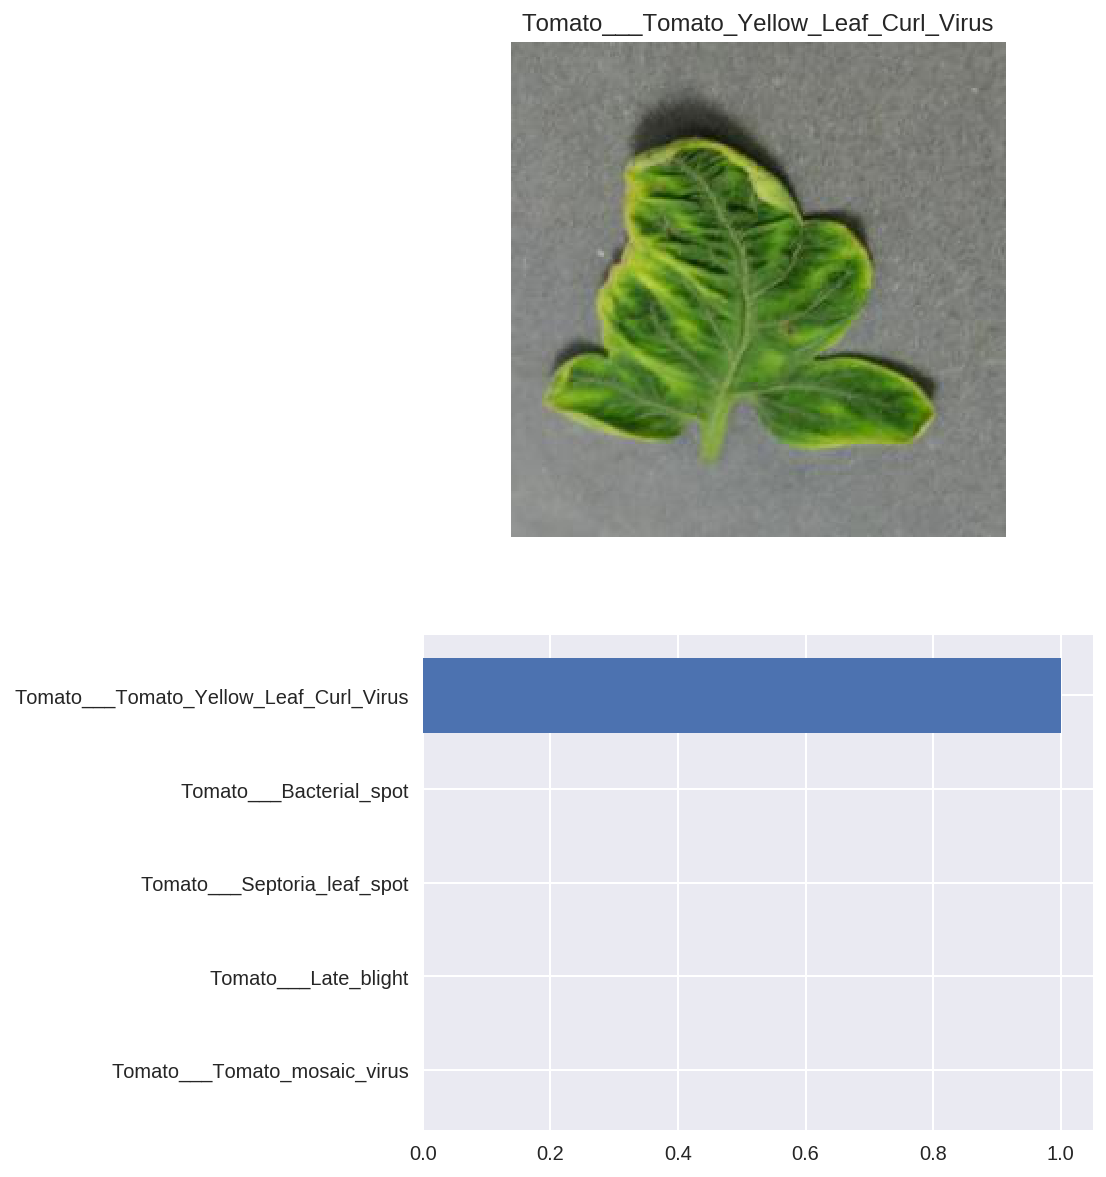

In [27]:
img = 'PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

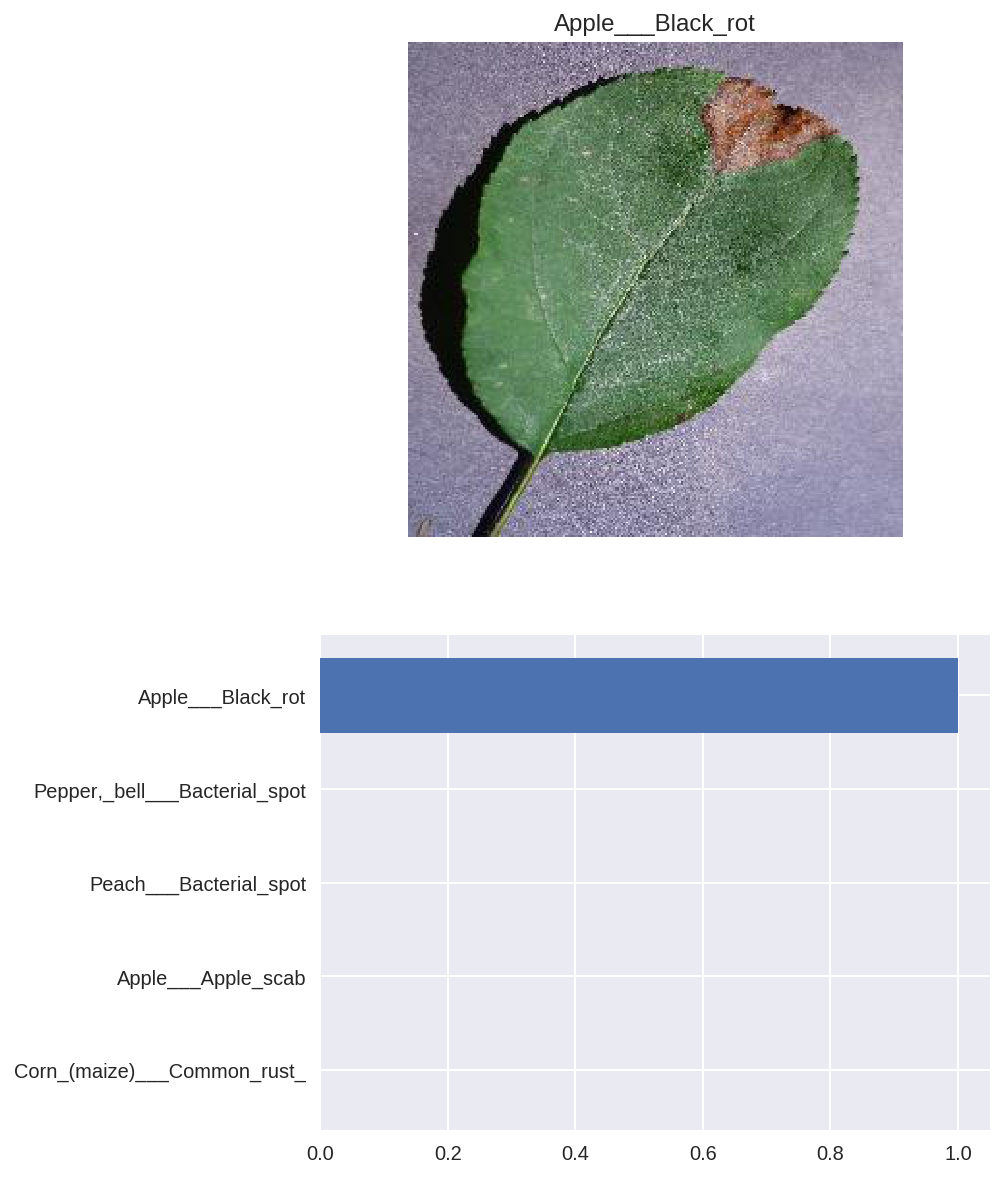

In [28]:
img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

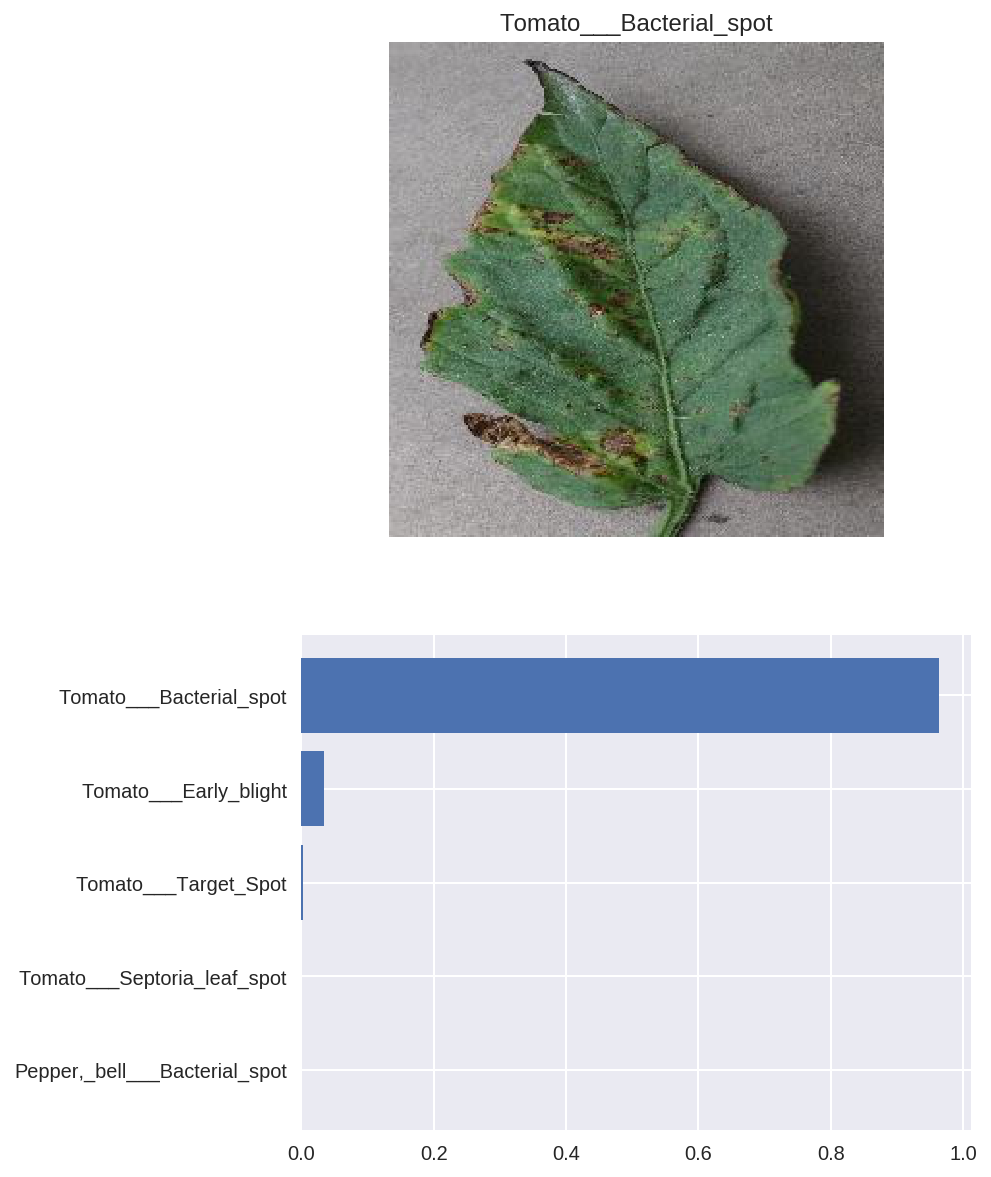

In [29]:
img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

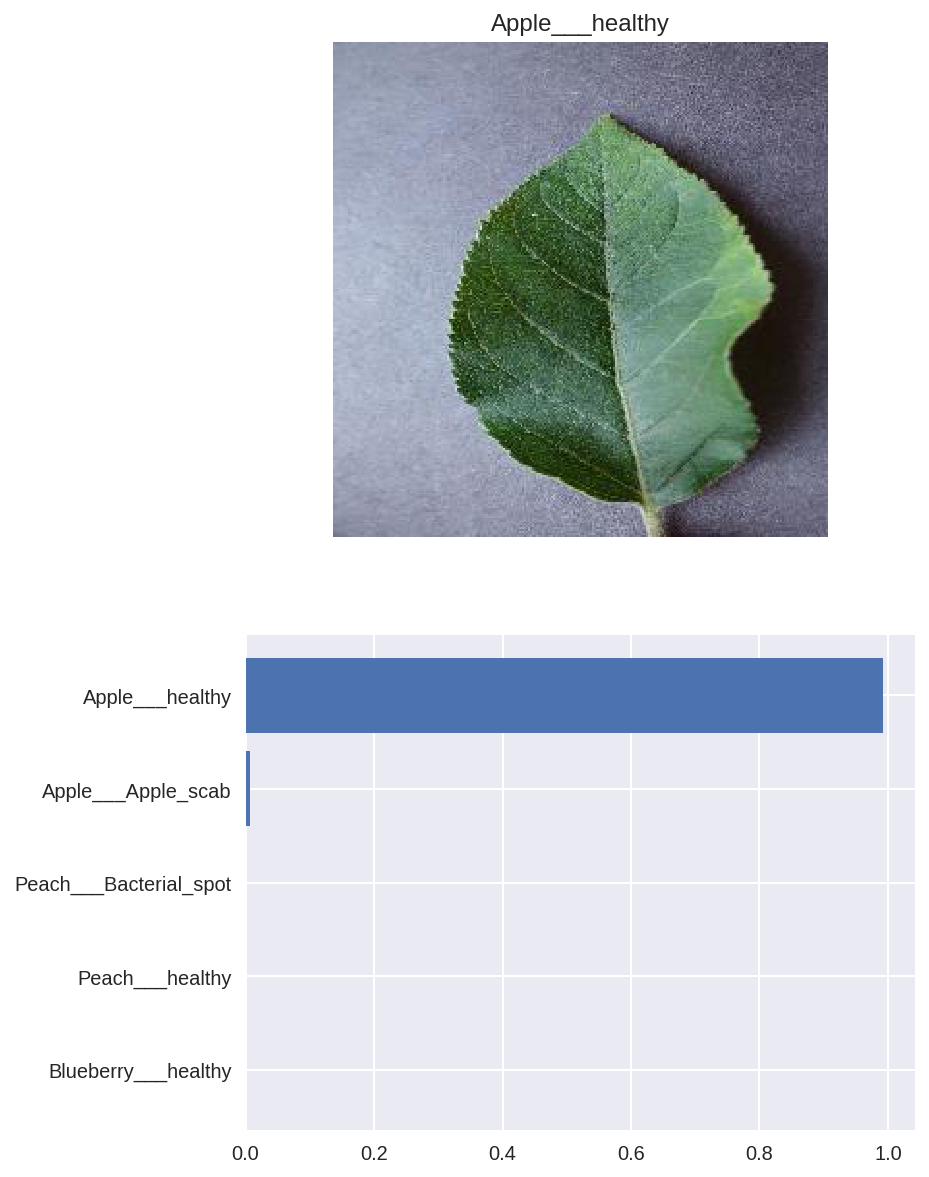

In [30]:
img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

# CONCLUSIONS

The model is deployed to get an application ready to use on the smarthphone!